# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [15]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = 'data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)
df

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.64,784.0,343.0,220.5,3.5,5,0.25,4,16.62,19.90
1,0.66,759.5,318.5,220.5,3.5,3,0.40,2,15.29,17.89
2,0.86,588.0,294.0,147.0,7.0,2,0.25,2,29.34,33.37
3,0.82,612.5,318.5,147.0,7.0,5,0.10,1,22.58,28.51
4,0.74,686.0,245.0,220.5,3.5,2,0.40,1,14.52,16.94
...,...,...,...,...,...,...,...,...,...,...
763,0.66,759.5,318.5,220.5,3.5,3,0.25,4,13.00,15.59
764,0.71,710.5,269.5,220.5,3.5,3,0.25,1,12.65,15.85
765,0.86,588.0,294.0,147.0,7.0,4,0.10,5,25.36,32.04
766,0.69,735.0,294.0,220.5,3.5,2,0.25,4,12.91,15.37


In [4]:
# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [11]:
len(train .columns)

8

In [12]:
train

,X1,X2,X3,X4,X5,X6,X7,X8
244,0.86,588.0,294.0,147.0,7.0,5,0.25,5
190,0.64,784.0,343.0,220.5,3.5,3,0.40,5
437,0.90,563.5,318.5,122.5,7.0,2,0.25,3
455,0.74,686.0,245.0,220.5,3.5,2,0.40,4
517,0.79,637.0,343.0,147.0,7.0,5,0.25,5
...,...,...,...,...,...,...,...,...
718,0.64,784.0,343.0,220.5,3.5,5,0.10,1
153,0.86,588.0,294.0,147.0,7.0,2,0.40,2
164,0.71,710.5,269.5,220.5,3.5,2,0.10,2
141,0.71,710.5,269.5,220.5,3.5,3,0.10,1


In [6]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense) #y1 output
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense) #y2 output

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          1152        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 64)           8256        ['dense_1[0][0]']                
                                                                                              

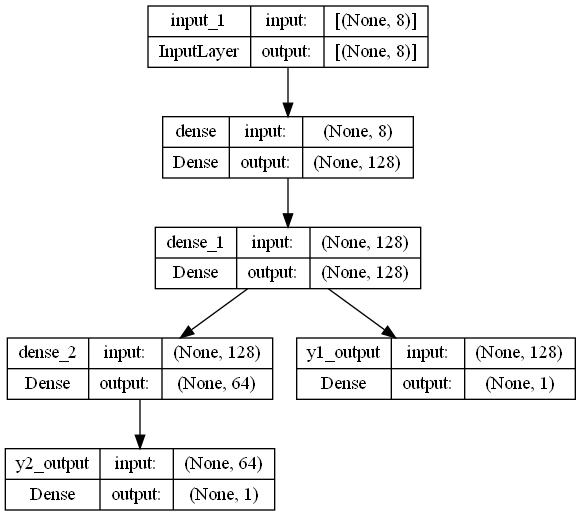

In [21]:
plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=False, to_file="functional_multi_outputs_model.png")

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [13]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [8]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 1s 7ms/step - loss: 244.7065 - y1_output_loss: 111.0257 - y2_output_loss: 133.6808 - y1_output_root_mean_squared_error: 10.5369 - y2_output_root_mean_squared_error: 11.5620 - val_loss: 23.4370 - val_y1_output_loss: 11.0447 - val_y2_output_loss: 12.3923 - val_y1_output_root_mean_squared_error: 3.3234 - val_y2_output_root_mean_squared_error: 3.5203
Epoch 2/500
62/62 [==============================] - 0s 3ms/step - loss: 33.1324 - y1_output_loss: 12.5825 - y2_output_loss: 20.5498 - y1_output_root_mean_squared_error: 3.5472 - y2_output_root_mean_squared_error: 4.5332 - val_loss: 20.6627 - val_y1_output_loss: 8.7279 - val_y2_output_loss: 11.9348 - val_y1_output_root_mean_squared_error: 2.9543 - val_y2_output_root_mean_squared_error: 3.4547
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 26.8054 - y1_output_loss: 10.2681 - y2_output_loss: 16.5373 - y1_output_root_mean_squared_error: 3.2044 - y2_output_root_mean_squ

Epoch 22/500
62/62 [==============================] - 0s 2ms/step - loss: 14.1480 - y1_output_loss: 5.3550 - y2_output_loss: 8.7931 - y1_output_root_mean_squared_error: 2.3141 - y2_output_root_mean_squared_error: 2.9653 - val_loss: 19.2539 - val_y1_output_loss: 7.0504 - val_y2_output_loss: 12.2034 - val_y1_output_root_mean_squared_error: 2.6553 - val_y2_output_root_mean_squared_error: 3.4933
Epoch 23/500
62/62 [==============================] - 0s 2ms/step - loss: 14.4239 - y1_output_loss: 5.3620 - y2_output_loss: 9.0619 - y1_output_root_mean_squared_error: 2.3156 - y2_output_root_mean_squared_error: 3.0103 - val_loss: 22.2820 - val_y1_output_loss: 7.4183 - val_y2_output_loss: 14.8637 - val_y1_output_root_mean_squared_error: 2.7237 - val_y2_output_root_mean_squared_error: 3.8553
Epoch 24/500
62/62 [==============================] - 0s 2ms/step - loss: 15.0793 - y1_output_loss: 5.4629 - y2_output_loss: 9.6164 - y1_output_root_mean_squared_error: 2.3373 - y2_output_root_mean_squared_erro

Epoch 43/500
62/62 [==============================] - 0s 2ms/step - loss: 8.9741 - y1_output_loss: 2.9433 - y2_output_loss: 6.0308 - y1_output_root_mean_squared_error: 1.7156 - y2_output_root_mean_squared_error: 2.4558 - val_loss: 7.8527 - val_y1_output_loss: 3.7272 - val_y2_output_loss: 4.1255 - val_y1_output_root_mean_squared_error: 1.9306 - val_y2_output_root_mean_squared_error: 2.0311
Epoch 44/500
62/62 [==============================] - 0s 2ms/step - loss: 7.0263 - y1_output_loss: 2.2770 - y2_output_loss: 4.7493 - y1_output_root_mean_squared_error: 1.5090 - y2_output_root_mean_squared_error: 2.1793 - val_loss: 54.6018 - val_y1_output_loss: 14.6096 - val_y2_output_loss: 39.9922 - val_y1_output_root_mean_squared_error: 3.8222 - val_y2_output_root_mean_squared_error: 6.3239
Epoch 45/500
62/62 [==============================] - 0s 2ms/step - loss: 8.5710 - y1_output_loss: 2.7119 - y2_output_loss: 5.8590 - y1_output_root_mean_squared_error: 1.6468 - y2_output_root_mean_squared_error: 2

Epoch 64/500
62/62 [==============================] - 0s 2ms/step - loss: 5.7231 - y1_output_loss: 1.7439 - y2_output_loss: 3.9793 - y1_output_root_mean_squared_error: 1.3206 - y2_output_root_mean_squared_error: 1.9948 - val_loss: 4.7072 - val_y1_output_loss: 2.0087 - val_y2_output_loss: 2.6985 - val_y1_output_root_mean_squared_error: 1.4173 - val_y2_output_root_mean_squared_error: 1.6427
Epoch 65/500
62/62 [==============================] - 0s 2ms/step - loss: 7.7802 - y1_output_loss: 2.5280 - y2_output_loss: 5.2523 - y1_output_root_mean_squared_error: 1.5900 - y2_output_root_mean_squared_error: 2.2918 - val_loss: 7.8163 - val_y1_output_loss: 2.6963 - val_y2_output_loss: 5.1200 - val_y1_output_root_mean_squared_error: 1.6420 - val_y2_output_root_mean_squared_error: 2.2627
Epoch 66/500
62/62 [==============================] - 0s 2ms/step - loss: 6.8529 - y1_output_loss: 1.9078 - y2_output_loss: 4.9451 - y1_output_root_mean_squared_error: 1.3812 - y2_output_root_mean_squared_error: 2.22

Epoch 85/500
62/62 [==============================] - 0s 2ms/step - loss: 4.4408 - y1_output_loss: 1.0978 - y2_output_loss: 3.3430 - y1_output_root_mean_squared_error: 1.0478 - y2_output_root_mean_squared_error: 1.8284 - val_loss: 8.6910 - val_y1_output_loss: 1.7070 - val_y2_output_loss: 6.9841 - val_y1_output_root_mean_squared_error: 1.3065 - val_y2_output_root_mean_squared_error: 2.6427
Epoch 86/500
62/62 [==============================] - 0s 2ms/step - loss: 7.0383 - y1_output_loss: 2.1692 - y2_output_loss: 4.8691 - y1_output_root_mean_squared_error: 1.4728 - y2_output_root_mean_squared_error: 2.2066 - val_loss: 5.4512 - val_y1_output_loss: 2.2640 - val_y2_output_loss: 3.1873 - val_y1_output_root_mean_squared_error: 1.5047 - val_y2_output_root_mean_squared_error: 1.7853
Epoch 87/500
62/62 [==============================] - 0s 2ms/step - loss: 3.4829 - y1_output_loss: 0.8379 - y2_output_loss: 2.6451 - y1_output_root_mean_squared_error: 0.9153 - y2_output_root_mean_squared_error: 1.62

Epoch 106/500
62/62 [==============================] - 0s 2ms/step - loss: 2.8593 - y1_output_loss: 0.7454 - y2_output_loss: 2.1139 - y1_output_root_mean_squared_error: 0.8634 - y2_output_root_mean_squared_error: 1.4539 - val_loss: 2.2092 - val_y1_output_loss: 0.6396 - val_y2_output_loss: 1.5696 - val_y1_output_root_mean_squared_error: 0.7997 - val_y2_output_root_mean_squared_error: 1.2529
Epoch 107/500
62/62 [==============================] - 0s 2ms/step - loss: 2.8397 - y1_output_loss: 0.7115 - y2_output_loss: 2.1283 - y1_output_root_mean_squared_error: 0.8435 - y2_output_root_mean_squared_error: 1.4589 - val_loss: 2.1194 - val_y1_output_loss: 0.5688 - val_y2_output_loss: 1.5506 - val_y1_output_root_mean_squared_error: 0.7542 - val_y2_output_root_mean_squared_error: 1.2452
Epoch 108/500
62/62 [==============================] - 0s 2ms/step - loss: 2.9313 - y1_output_loss: 0.5931 - y2_output_loss: 2.3382 - y1_output_root_mean_squared_error: 0.7701 - y2_output_root_mean_squared_error: 1

Epoch 127/500
62/62 [==============================] - 0s 2ms/step - loss: 1.6587 - y1_output_loss: 0.3859 - y2_output_loss: 1.2728 - y1_output_root_mean_squared_error: 0.6212 - y2_output_root_mean_squared_error: 1.1282 - val_loss: 1.9431 - val_y1_output_loss: 0.6216 - val_y2_output_loss: 1.3215 - val_y1_output_root_mean_squared_error: 0.7884 - val_y2_output_root_mean_squared_error: 1.1496
Epoch 128/500
62/62 [==============================] - 0s 2ms/step - loss: 3.5852 - y1_output_loss: 0.8584 - y2_output_loss: 2.7268 - y1_output_root_mean_squared_error: 0.9265 - y2_output_root_mean_squared_error: 1.6513 - val_loss: 2.9801 - val_y1_output_loss: 0.7863 - val_y2_output_loss: 2.1938 - val_y1_output_root_mean_squared_error: 0.8867 - val_y2_output_root_mean_squared_error: 1.4811
Epoch 129/500
62/62 [==============================] - 0s 2ms/step - loss: 1.9308 - y1_output_loss: 0.4459 - y2_output_loss: 1.4849 - y1_output_root_mean_squared_error: 0.6678 - y2_output_root_mean_squared_error: 1

Epoch 148/500
62/62 [==============================] - 0s 2ms/step - loss: 1.3814 - y1_output_loss: 0.3198 - y2_output_loss: 1.0616 - y1_output_root_mean_squared_error: 0.5655 - y2_output_root_mean_squared_error: 1.0303 - val_loss: 2.2572 - val_y1_output_loss: 0.6373 - val_y2_output_loss: 1.6199 - val_y1_output_root_mean_squared_error: 0.7983 - val_y2_output_root_mean_squared_error: 1.2728
Epoch 149/500
62/62 [==============================] - 0s 2ms/step - loss: 1.6178 - y1_output_loss: 0.3601 - y2_output_loss: 1.2578 - y1_output_root_mean_squared_error: 0.6001 - y2_output_root_mean_squared_error: 1.1215 - val_loss: 2.4786 - val_y1_output_loss: 0.7843 - val_y2_output_loss: 1.6943 - val_y1_output_root_mean_squared_error: 0.8856 - val_y2_output_root_mean_squared_error: 1.3016
Epoch 150/500
62/62 [==============================] - 0s 2ms/step - loss: 3.1325 - y1_output_loss: 0.7317 - y2_output_loss: 2.4007 - y1_output_root_mean_squared_error: 0.8554 - y2_output_root_mean_squared_error: 1

Epoch 169/500
62/62 [==============================] - 0s 2ms/step - loss: 1.3253 - y1_output_loss: 0.2783 - y2_output_loss: 1.0470 - y1_output_root_mean_squared_error: 0.5276 - y2_output_root_mean_squared_error: 1.0232 - val_loss: 1.7914 - val_y1_output_loss: 0.4693 - val_y2_output_loss: 1.3221 - val_y1_output_root_mean_squared_error: 0.6851 - val_y2_output_root_mean_squared_error: 1.1498
Epoch 170/500
62/62 [==============================] - 0s 2ms/step - loss: 1.5244 - y1_output_loss: 0.3300 - y2_output_loss: 1.1944 - y1_output_root_mean_squared_error: 0.5745 - y2_output_root_mean_squared_error: 1.0929 - val_loss: 2.2272 - val_y1_output_loss: 0.6243 - val_y2_output_loss: 1.6028 - val_y1_output_root_mean_squared_error: 0.7902 - val_y2_output_root_mean_squared_error: 1.2660
Epoch 171/500
62/62 [==============================] - 0s 2ms/step - loss: 1.7050 - y1_output_loss: 0.3371 - y2_output_loss: 1.3679 - y1_output_root_mean_squared_error: 0.5806 - y2_output_root_mean_squared_error: 1

Epoch 190/500
62/62 [==============================] - 0s 2ms/step - loss: 1.0854 - y1_output_loss: 0.2671 - y2_output_loss: 0.8184 - y1_output_root_mean_squared_error: 0.5168 - y2_output_root_mean_squared_error: 0.9046 - val_loss: 1.6180 - val_y1_output_loss: 0.3546 - val_y2_output_loss: 1.2634 - val_y1_output_root_mean_squared_error: 0.5954 - val_y2_output_root_mean_squared_error: 1.1240
Epoch 191/500
62/62 [==============================] - 0s 2ms/step - loss: 1.5317 - y1_output_loss: 0.3097 - y2_output_loss: 1.2220 - y1_output_root_mean_squared_error: 0.5565 - y2_output_root_mean_squared_error: 1.1055 - val_loss: 1.4000 - val_y1_output_loss: 0.3906 - val_y2_output_loss: 1.0094 - val_y1_output_root_mean_squared_error: 0.6250 - val_y2_output_root_mean_squared_error: 1.0047
Epoch 192/500
62/62 [==============================] - 0s 2ms/step - loss: 1.0589 - y1_output_loss: 0.2064 - y2_output_loss: 0.8525 - y1_output_root_mean_squared_error: 0.4543 - y2_output_root_mean_squared_error: 0

Epoch 211/500
62/62 [==============================] - 0s 2ms/step - loss: 0.9730 - y1_output_loss: 0.1930 - y2_output_loss: 0.7800 - y1_output_root_mean_squared_error: 0.4393 - y2_output_root_mean_squared_error: 0.8832 - val_loss: 1.6079 - val_y1_output_loss: 0.3115 - val_y2_output_loss: 1.2964 - val_y1_output_root_mean_squared_error: 0.5581 - val_y2_output_root_mean_squared_error: 1.1386
Epoch 212/500
62/62 [==============================] - 0s 2ms/step - loss: 0.8590 - y1_output_loss: 0.1742 - y2_output_loss: 0.6849 - y1_output_root_mean_squared_error: 0.4173 - y2_output_root_mean_squared_error: 0.8276 - val_loss: 5.3672 - val_y1_output_loss: 1.1589 - val_y2_output_loss: 4.2084 - val_y1_output_root_mean_squared_error: 1.0765 - val_y2_output_root_mean_squared_error: 2.0514
Epoch 213/500
62/62 [==============================] - 0s 2ms/step - loss: 1.5019 - y1_output_loss: 0.3012 - y2_output_loss: 1.2007 - y1_output_root_mean_squared_error: 0.5489 - y2_output_root_mean_squared_error: 1

Epoch 232/500
62/62 [==============================] - 0s 2ms/step - loss: 1.1009 - y1_output_loss: 0.2209 - y2_output_loss: 0.8801 - y1_output_root_mean_squared_error: 0.4700 - y2_output_root_mean_squared_error: 0.9381 - val_loss: 1.3401 - val_y1_output_loss: 0.3211 - val_y2_output_loss: 1.0190 - val_y1_output_root_mean_squared_error: 0.5666 - val_y2_output_root_mean_squared_error: 1.0095
Epoch 233/500
62/62 [==============================] - 0s 2ms/step - loss: 1.5351 - y1_output_loss: 0.2553 - y2_output_loss: 1.2798 - y1_output_root_mean_squared_error: 0.5052 - y2_output_root_mean_squared_error: 1.1313 - val_loss: 6.1668 - val_y1_output_loss: 1.2378 - val_y2_output_loss: 4.9290 - val_y1_output_root_mean_squared_error: 1.1126 - val_y2_output_root_mean_squared_error: 2.2201
Epoch 234/500
62/62 [==============================] - 0s 2ms/step - loss: 1.1559 - y1_output_loss: 0.2330 - y2_output_loss: 0.9229 - y1_output_root_mean_squared_error: 0.4827 - y2_output_root_mean_squared_error: 0

Epoch 253/500
62/62 [==============================] - 0s 2ms/step - loss: 0.8163 - y1_output_loss: 0.1810 - y2_output_loss: 0.6353 - y1_output_root_mean_squared_error: 0.4254 - y2_output_root_mean_squared_error: 0.7971 - val_loss: 1.2820 - val_y1_output_loss: 0.3044 - val_y2_output_loss: 0.9776 - val_y1_output_root_mean_squared_error: 0.5517 - val_y2_output_root_mean_squared_error: 0.9887
Epoch 254/500
62/62 [==============================] - 0s 2ms/step - loss: 1.0290 - y1_output_loss: 0.1868 - y2_output_loss: 0.8422 - y1_output_root_mean_squared_error: 0.4323 - y2_output_root_mean_squared_error: 0.9177 - val_loss: 1.3320 - val_y1_output_loss: 0.4489 - val_y2_output_loss: 0.8831 - val_y1_output_root_mean_squared_error: 0.6700 - val_y2_output_root_mean_squared_error: 0.9398
Epoch 255/500
62/62 [==============================] - 0s 2ms/step - loss: 0.7530 - y1_output_loss: 0.1561 - y2_output_loss: 0.5968 - y1_output_root_mean_squared_error: 0.3952 - y2_output_root_mean_squared_error: 0

Epoch 274/500
62/62 [==============================] - 0s 2ms/step - loss: 0.8279 - y1_output_loss: 0.1845 - y2_output_loss: 0.6434 - y1_output_root_mean_squared_error: 0.4295 - y2_output_root_mean_squared_error: 0.8021 - val_loss: 1.0694 - val_y1_output_loss: 0.2786 - val_y2_output_loss: 0.7907 - val_y1_output_root_mean_squared_error: 0.5279 - val_y2_output_root_mean_squared_error: 0.8892
Epoch 275/500
62/62 [==============================] - 0s 2ms/step - loss: 0.6469 - y1_output_loss: 0.1350 - y2_output_loss: 0.5118 - y1_output_root_mean_squared_error: 0.3675 - y2_output_root_mean_squared_error: 0.7154 - val_loss: 1.1756 - val_y1_output_loss: 0.2718 - val_y2_output_loss: 0.9038 - val_y1_output_root_mean_squared_error: 0.5214 - val_y2_output_root_mean_squared_error: 0.9507
Epoch 276/500
62/62 [==============================] - 0s 2ms/step - loss: 0.7690 - y1_output_loss: 0.1760 - y2_output_loss: 0.5930 - y1_output_root_mean_squared_error: 0.4195 - y2_output_root_mean_squared_error: 0

Epoch 295/500
62/62 [==============================] - 0s 2ms/step - loss: 0.7846 - y1_output_loss: 0.1839 - y2_output_loss: 0.6008 - y1_output_root_mean_squared_error: 0.4288 - y2_output_root_mean_squared_error: 0.7751 - val_loss: 1.2353 - val_y1_output_loss: 0.3387 - val_y2_output_loss: 0.8967 - val_y1_output_root_mean_squared_error: 0.5819 - val_y2_output_root_mean_squared_error: 0.9469
Epoch 296/500
62/62 [==============================] - 0s 2ms/step - loss: 0.6156 - y1_output_loss: 0.1396 - y2_output_loss: 0.4759 - y1_output_root_mean_squared_error: 0.3737 - y2_output_root_mean_squared_error: 0.6899 - val_loss: 1.1648 - val_y1_output_loss: 0.2845 - val_y2_output_loss: 0.8803 - val_y1_output_root_mean_squared_error: 0.5334 - val_y2_output_root_mean_squared_error: 0.9382
Epoch 297/500
62/62 [==============================] - 0s 2ms/step - loss: 0.7538 - y1_output_loss: 0.1665 - y2_output_loss: 0.5873 - y1_output_root_mean_squared_error: 0.4080 - y2_output_root_mean_squared_error: 0

Epoch 316/500
62/62 [==============================] - 0s 2ms/step - loss: 0.8135 - y1_output_loss: 0.1867 - y2_output_loss: 0.6268 - y1_output_root_mean_squared_error: 0.4321 - y2_output_root_mean_squared_error: 0.7917 - val_loss: 1.0966 - val_y1_output_loss: 0.2884 - val_y2_output_loss: 0.8082 - val_y1_output_root_mean_squared_error: 0.5370 - val_y2_output_root_mean_squared_error: 0.8990
Epoch 317/500
62/62 [==============================] - 0s 2ms/step - loss: 0.6120 - y1_output_loss: 0.1453 - y2_output_loss: 0.4666 - y1_output_root_mean_squared_error: 0.3812 - y2_output_root_mean_squared_error: 0.6831 - val_loss: 2.0604 - val_y1_output_loss: 0.3258 - val_y2_output_loss: 1.7346 - val_y1_output_root_mean_squared_error: 0.5708 - val_y2_output_root_mean_squared_error: 1.3171
Epoch 318/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5620 - y1_output_loss: 0.1292 - y2_output_loss: 0.4328 - y1_output_root_mean_squared_error: 0.3595 - y2_output_root_mean_squared_error: 0

Epoch 337/500
62/62 [==============================] - 0s 2ms/step - loss: 0.7168 - y1_output_loss: 0.1502 - y2_output_loss: 0.5666 - y1_output_root_mean_squared_error: 0.3876 - y2_output_root_mean_squared_error: 0.7527 - val_loss: 1.4946 - val_y1_output_loss: 0.3864 - val_y2_output_loss: 1.1083 - val_y1_output_root_mean_squared_error: 0.6216 - val_y2_output_root_mean_squared_error: 1.0527
Epoch 338/500
62/62 [==============================] - 0s 2ms/step - loss: 0.6203 - y1_output_loss: 0.1540 - y2_output_loss: 0.4663 - y1_output_root_mean_squared_error: 0.3924 - y2_output_root_mean_squared_error: 0.6829 - val_loss: 1.5209 - val_y1_output_loss: 0.2954 - val_y2_output_loss: 1.2255 - val_y1_output_root_mean_squared_error: 0.5435 - val_y2_output_root_mean_squared_error: 1.1070
Epoch 339/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5581 - y1_output_loss: 0.1432 - y2_output_loss: 0.4149 - y1_output_root_mean_squared_error: 0.3785 - y2_output_root_mean_squared_error: 0

Epoch 358/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4671 - y1_output_loss: 0.1324 - y2_output_loss: 0.3347 - y1_output_root_mean_squared_error: 0.3638 - y2_output_root_mean_squared_error: 0.5786 - val_loss: 0.9311 - val_y1_output_loss: 0.3087 - val_y2_output_loss: 0.6224 - val_y1_output_root_mean_squared_error: 0.5556 - val_y2_output_root_mean_squared_error: 0.7889
Epoch 359/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4768 - y1_output_loss: 0.1241 - y2_output_loss: 0.3527 - y1_output_root_mean_squared_error: 0.3522 - y2_output_root_mean_squared_error: 0.5939 - val_loss: 1.0165 - val_y1_output_loss: 0.2648 - val_y2_output_loss: 0.7517 - val_y1_output_root_mean_squared_error: 0.5146 - val_y2_output_root_mean_squared_error: 0.8670
Epoch 360/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5800 - y1_output_loss: 0.1378 - y2_output_loss: 0.4422 - y1_output_root_mean_squared_error: 0.3712 - y2_output_root_mean_squared_error: 0

Epoch 379/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4201 - y1_output_loss: 0.1134 - y2_output_loss: 0.3067 - y1_output_root_mean_squared_error: 0.3367 - y2_output_root_mean_squared_error: 0.5538 - val_loss: 0.8362 - val_y1_output_loss: 0.2538 - val_y2_output_loss: 0.5824 - val_y1_output_root_mean_squared_error: 0.5038 - val_y2_output_root_mean_squared_error: 0.7632
Epoch 380/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5393 - y1_output_loss: 0.1390 - y2_output_loss: 0.4003 - y1_output_root_mean_squared_error: 0.3728 - y2_output_root_mean_squared_error: 0.6327 - val_loss: 1.4077 - val_y1_output_loss: 0.5556 - val_y2_output_loss: 0.8522 - val_y1_output_root_mean_squared_error: 0.7454 - val_y2_output_root_mean_squared_error: 0.9231
Epoch 381/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5042 - y1_output_loss: 0.1256 - y2_output_loss: 0.3786 - y1_output_root_mean_squared_error: 0.3544 - y2_output_root_mean_squared_error: 0

Epoch 400/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4204 - y1_output_loss: 0.1219 - y2_output_loss: 0.2984 - y1_output_root_mean_squared_error: 0.3492 - y2_output_root_mean_squared_error: 0.5463 - val_loss: 1.0062 - val_y1_output_loss: 0.2965 - val_y2_output_loss: 0.7097 - val_y1_output_root_mean_squared_error: 0.5445 - val_y2_output_root_mean_squared_error: 0.8425
Epoch 401/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3914 - y1_output_loss: 0.1012 - y2_output_loss: 0.2902 - y1_output_root_mean_squared_error: 0.3181 - y2_output_root_mean_squared_error: 0.5387 - val_loss: 0.8568 - val_y1_output_loss: 0.3049 - val_y2_output_loss: 0.5519 - val_y1_output_root_mean_squared_error: 0.5521 - val_y2_output_root_mean_squared_error: 0.7429
Epoch 402/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5391 - y1_output_loss: 0.1341 - y2_output_loss: 0.4049 - y1_output_root_mean_squared_error: 0.3662 - y2_output_root_mean_squared_error: 0

Epoch 421/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3538 - y1_output_loss: 0.0953 - y2_output_loss: 0.2584 - y1_output_root_mean_squared_error: 0.3087 - y2_output_root_mean_squared_error: 0.5084 - val_loss: 1.4866 - val_y1_output_loss: 0.3926 - val_y2_output_loss: 1.0939 - val_y1_output_root_mean_squared_error: 0.6266 - val_y2_output_root_mean_squared_error: 1.0459
Epoch 422/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5801 - y1_output_loss: 0.1442 - y2_output_loss: 0.4359 - y1_output_root_mean_squared_error: 0.3797 - y2_output_root_mean_squared_error: 0.6602 - val_loss: 1.0102 - val_y1_output_loss: 0.3030 - val_y2_output_loss: 0.7073 - val_y1_output_root_mean_squared_error: 0.5504 - val_y2_output_root_mean_squared_error: 0.8410
Epoch 423/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3835 - y1_output_loss: 0.1224 - y2_output_loss: 0.2611 - y1_output_root_mean_squared_error: 0.3499 - y2_output_root_mean_squared_error: 0

Epoch 442/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3921 - y1_output_loss: 0.1126 - y2_output_loss: 0.2795 - y1_output_root_mean_squared_error: 0.3356 - y2_output_root_mean_squared_error: 0.5287 - val_loss: 0.9176 - val_y1_output_loss: 0.2425 - val_y2_output_loss: 0.6751 - val_y1_output_root_mean_squared_error: 0.4924 - val_y2_output_root_mean_squared_error: 0.8217
Epoch 443/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4335 - y1_output_loss: 0.1111 - y2_output_loss: 0.3224 - y1_output_root_mean_squared_error: 0.3333 - y2_output_root_mean_squared_error: 0.5678 - val_loss: 1.1024 - val_y1_output_loss: 0.3281 - val_y2_output_loss: 0.7743 - val_y1_output_root_mean_squared_error: 0.5728 - val_y2_output_root_mean_squared_error: 0.8800
Epoch 444/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3852 - y1_output_loss: 0.1153 - y2_output_loss: 0.2699 - y1_output_root_mean_squared_error: 0.3395 - y2_output_root_mean_squared_error: 0

Epoch 463/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3622 - y1_output_loss: 0.1138 - y2_output_loss: 0.2483 - y1_output_root_mean_squared_error: 0.3374 - y2_output_root_mean_squared_error: 0.4983 - val_loss: 0.8603 - val_y1_output_loss: 0.2685 - val_y2_output_loss: 0.5919 - val_y1_output_root_mean_squared_error: 0.5181 - val_y2_output_root_mean_squared_error: 0.7693
Epoch 464/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4110 - y1_output_loss: 0.1238 - y2_output_loss: 0.2872 - y1_output_root_mean_squared_error: 0.3519 - y2_output_root_mean_squared_error: 0.5359 - val_loss: 0.8387 - val_y1_output_loss: 0.3390 - val_y2_output_loss: 0.4997 - val_y1_output_root_mean_squared_error: 0.5822 - val_y2_output_root_mean_squared_error: 0.7069
Epoch 465/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3353 - y1_output_loss: 0.1004 - y2_output_loss: 0.2349 - y1_output_root_mean_squared_error: 0.3168 - y2_output_root_mean_squared_error: 0

Epoch 484/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4914 - y1_output_loss: 0.1392 - y2_output_loss: 0.3521 - y1_output_root_mean_squared_error: 0.3732 - y2_output_root_mean_squared_error: 0.5934 - val_loss: 0.7282 - val_y1_output_loss: 0.2364 - val_y2_output_loss: 0.4918 - val_y1_output_root_mean_squared_error: 0.4863 - val_y2_output_root_mean_squared_error: 0.7013
Epoch 485/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4160 - y1_output_loss: 0.1121 - y2_output_loss: 0.3039 - y1_output_root_mean_squared_error: 0.3349 - y2_output_root_mean_squared_error: 0.5513 - val_loss: 1.5705 - val_y1_output_loss: 0.3516 - val_y2_output_loss: 1.2189 - val_y1_output_root_mean_squared_error: 0.5929 - val_y2_output_root_mean_squared_error: 1.1040
Epoch 486/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3554 - y1_output_loss: 0.1000 - y2_output_loss: 0.2554 - y1_output_root_mean_squared_error: 0.3163 - y2_output_root_mean_squared_error: 0

## Evaluate the Model and Plot Metrics

In [9]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 3ms/step - loss: 1.2114 - y1_output_loss: 0.2791 - y2_output_loss: 0.9322 - y1_output_root_mean_squared_error: 0.5283 - y2_output_root_mean_squared_error: 0.9655
Loss = 1.2113851308822632, Y1_loss = 0.2791461944580078, Y1_mse = 0.5283429026603699, Y2_loss = 0.9322389960289001, Y2_mse = 0.9655252695083618


5/5 [==============================] - 0s 3ms/step


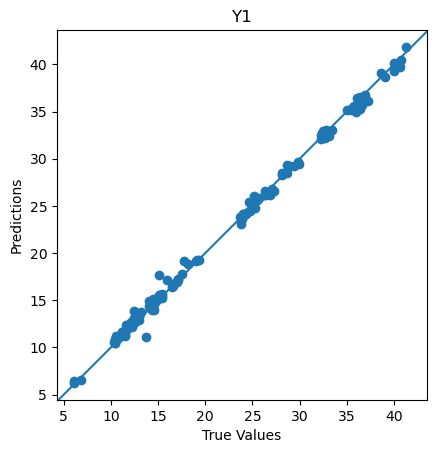

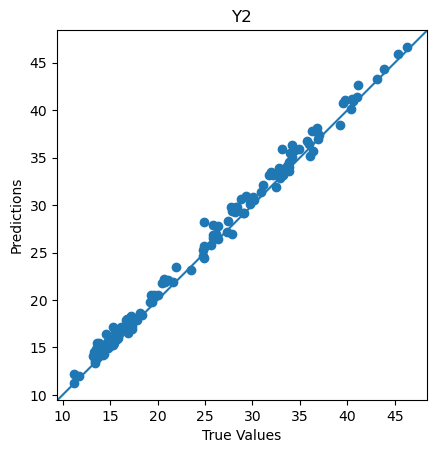

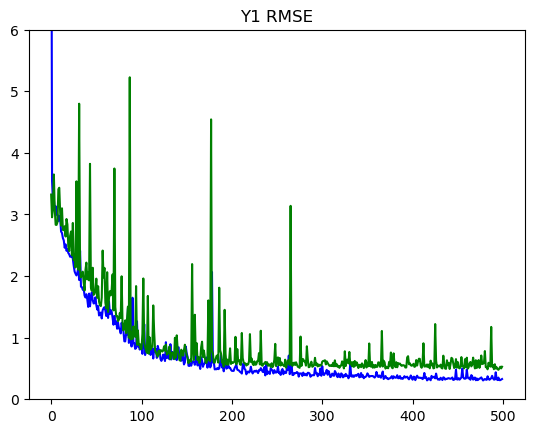

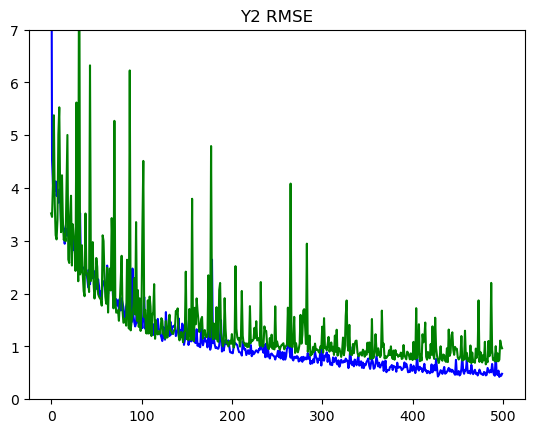

In [10]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)